# Antenna Placement Optimization - Algorithm Comparison

This notebook implements and compares **multiple algorithms** for antenna placement optimization on a grid.

## Problem Description

Given:
- A grid with houses that need cellular coverage
- Three antenna types with different costs and coverage radius
- Each house contains **100 users**
- Antennas **cannot** be placed on houses

Goal:
- Cover all houses (100% coverage)
- Minimize total antenna deployment cost
- Use the most cost-efficient antenna placements

## Algorithms Implemented

1. **Greedy Algorithm**: Fast, cost-efficiency based selection (locally optimal)
2. **Genetic Algorithm**: Evolutionary approach, explores solution space (potentially globally optimal)

Each algorithm solves the same problem independently, and we compare their performance at the end.

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set, Dict
from enum import Enum
import time
import random
from copy import deepcopy

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Constants and Antenna Specifications

We define three antenna types with their properties:
- **Small**: Shortest range, cheapest
- **Medium**: Moderate range and cost
- **Large**: Longest range, most expensive

In [2]:
# Constants
USERS_PER_HOUSE = 100

# Antenna Types
class AntennaType(str, Enum):
    SMALL = "Small"
    MEDIUM = "Medium"
    LARGE = "Large"

# Antenna Specifications
class AntennaSpec:
    def __init__(self, type: AntennaType, radius: int, cost: int):
        self.type = type
        self.radius = radius
        self.cost = cost
    
    def __repr__(self):
        return f"{self.type.value}(radius={self.radius}, cost=${self.cost})"

# Define antenna specifications
ANTENNA_SPECS = {
    AntennaType.SMALL: AntennaSpec(AntennaType.SMALL, radius=2, cost=1000),
    AntennaType.MEDIUM: AntennaSpec(AntennaType.MEDIUM, radius=4, cost=1500),
    AntennaType.LARGE: AntennaSpec(AntennaType.LARGE, radius=6, cost=2000),
}

print("Antenna Specifications:")
for spec in ANTENNA_SPECS.values():
    print(f"  {spec}")

Antenna Specifications:
  Small(radius=2, cost=$1000)
  Medium(radius=4, cost=$1500)
  Large(radius=6, cost=$2000)


## Implement Greedy Algorithm Class

The `GreedyAlgorithm` class implements a simplified cost-optimized approach:
1. Finds the antenna placement that covers the most uncovered houses at the lowest cost per house
2. Continues until all houses are covered (100% coverage)
3. Antennas cannot be placed on houses

In [ ]:
class GreedyAlgorithm:
    """Simplified greedy algorithm for cost-optimized antenna placement."""
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]]
    ):
        """
        Initialize the greedy algorithm.
        
        Args:
            width: Grid width
            height: Grid height
            antenna_specs: Dictionary of antenna specifications
            houses: List of house coordinates (each has 100 users)
        """
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.covered_houses: Set[Tuple[int, int]] = set()
        self.placed_antennas: List[Dict] = []
        
        print(f"Initialized: {width}x{height} grid, {len(houses)} houses, {len(houses) * USERS_PER_HOUSE} total users")
    
    def get_covered_houses(self, x: int, y: int, radius: int) -> Set[Tuple[int, int]]:
        """Calculate which houses are covered by an antenna at position (x, y)."""
        covered = set()
        
        for house_x, house_y in self.houses:
            # Euclidean distance
            distance = ((x - house_x) ** 2 + (y - house_y) ** 2) ** 0.5
            if distance <= radius:
                covered.add((house_x, house_y))
        
        return covered
    
    def is_valid_position(self, x: int, y: int) -> bool:
        """Check if a position is valid for antenna placement (not on a house)."""
        return (0 <= x < self.width and 
                0 <= y < self.height and 
                (x, y) not in self.houses)
    
    def find_best_antenna_placement(self):
        """Find the best antenna placement with lowest cost per new house covered."""
        best_position = None
        best_antenna_type = None
        best_cost_efficiency = float('inf')  # Lower is better
        best_new_houses = set()
        
        # Try all antenna types
        for antenna_type, spec in self.antenna_specs.items():
            # Try all positions on the grid
            for x in range(self.width):
                for y in range(self.height):
                    if not self.is_valid_position(x, y):
                        continue
                    
                    # Calculate coverage
                    covered = self.get_covered_houses(x, y, spec.radius)
                    new_houses = covered - self.covered_houses
                    
                    if len(new_houses) > 0:
                        # Cost efficiency = cost per new house covered
                        cost_efficiency = spec.cost / len(new_houses)
                        
                        if cost_efficiency < best_cost_efficiency:
                            best_cost_efficiency = cost_efficiency
                            best_position = (x, y)
                            best_antenna_type = antenna_type
                            best_new_houses = new_houses
        
        if best_position is None:
            return None
        
        return best_position, best_antenna_type, best_new_houses
    
    def optimize(self) -> Dict:
        """Run the greedy algorithm to minimize cost while covering all houses."""
        print("\\nStarting greedy optimization...")
        
        start_time = time.time()
        total_houses = len(self.houses)
        iteration = 0
        
        # Continue until all houses are covered
        while len(self.covered_houses) < total_houses:
            iteration += 1
            
            # Find best antenna placement
            result = self.find_best_antenna_placement()
            
            if result is None:
                print(f"\\n⚠ Warning: Could not cover all houses. {len(self.covered_houses)}/{total_houses} covered.")
                break
            
            position, antenna_type, new_houses = result
            spec = self.antenna_specs[antenna_type]
            
            # Place antenna
            antenna_data = {
                "x": position[0],
                "y": position[1],
                "type": antenna_type,
                "radius": spec.radius,
                "cost": spec.cost
            }
            self.placed_antennas.append(antenna_data)
            
            # Update coverage
            self.covered_houses.update(new_houses)
            
            coverage_percent = (len(self.covered_houses) / total_houses * 100)
            
            print(f"  Iteration {iteration}: Placed {antenna_type.value} at {position}, "
                  f"covered {len(new_houses)} new houses, total coverage: {coverage_percent:.1f}%")
        
        # Calculate final statistics
        total_users = total_houses * USERS_PER_HOUSE
        houses_covered = len(self.covered_houses)
        users_covered = houses_covered * USERS_PER_HOUSE
        coverage_percentage = (users_covered / total_users * 100) if total_users > 0 else 0
        total_cost = sum(ant["cost"] for ant in self.placed_antennas)
        execution_time_ms = (time.time() - start_time) * 1000
        
        print(f"\\n✓ Optimization complete!")
        print(f"  Antennas placed: {len(self.placed_antennas)}")
        print(f"  Total cost: ${total_cost:,}")
        print(f"  Houses covered: {houses_covered}/{total_houses}")
        print(f"  Users covered: {users_covered:,}/{total_users:,} ({coverage_percentage:.1f}%)")
        
        return {
            "antennas": self.placed_antennas,
            "houses_covered": houses_covered,
            "total_houses": total_houses,
            "users_covered": users_covered,
            "total_users": total_users,
            "coverage_percentage": coverage_percentage,
            "total_cost": total_cost,
            "execution_time_ms": execution_time_ms
        }

print("GreedyAlgorithm class defined successfully!")

GreedyAlgorithm class defined successfully!


## Example: Run Optimization on Sample Grid

Let's create a sample grid with random house placements and run the optimization.

In [4]:
# Create a sample grid
np.random.seed(42)
GRID_WIDTH = 20
GRID_HEIGHT = 15

# Generate random house positions (15% of grid cells)
num_houses = int(GRID_WIDTH * GRID_HEIGHT * 0.15)
houses = []
while len(houses) < num_houses:
    x = np.random.randint(0, GRID_WIDTH)
    y = np.random.randint(0, GRID_HEIGHT)
    if (x, y) not in houses:
        houses.append((x, y))

print(f"Grid size: {GRID_WIDTH}x{GRID_HEIGHT}")
print(f"Number of houses: {len(houses)}")
print(f"Total users: {len(houses) * USERS_PER_HOUSE}")

# Initialize and run the greedy algorithm
algorithm = GreedyAlgorithm(
    width=GRID_WIDTH,
    height=GRID_HEIGHT,
    antenna_specs=ANTENNA_SPECS,
    houses=houses
)

result = algorithm.optimize()

Grid size: 20x15
Number of houses: 45
Total users: 4500
Initialized: 20x15 grid, 45 houses, 4500 total users
\nStarting greedy optimization...
  Iteration 1: Placed Large at (6, 8), covered 21 new houses, total coverage: 46.7%
  Iteration 2: Placed Medium at (17, 11), covered 12 new houses, total coverage: 73.3%
  Iteration 3: Placed Medium at (13, 3), covered 4 new houses, total coverage: 82.2%
  Iteration 4: Placed Small at (0, 13), covered 2 new houses, total coverage: 86.7%
  Iteration 5: Placed Small at (1, 1), covered 2 new houses, total coverage: 91.1%
  Iteration 6: Placed Medium at (8, 11), covered 2 new houses, total coverage: 95.6%
  Iteration 7: Placed Small at (4, 0), covered 1 new houses, total coverage: 97.8%
  Iteration 8: Placed Small at (16, 6), covered 1 new houses, total coverage: 100.0%
\n✓ Optimization complete!
  Antennas placed: 8
  Total cost: $10,500
  Houses covered: 45/45
  Users covered: 4,500/4,500 (100.0%)


## Visualize Results

Create a visualization showing:
- Houses (red squares)
- Antennas (colored by type)
- Coverage areas (semi-transparent circles)

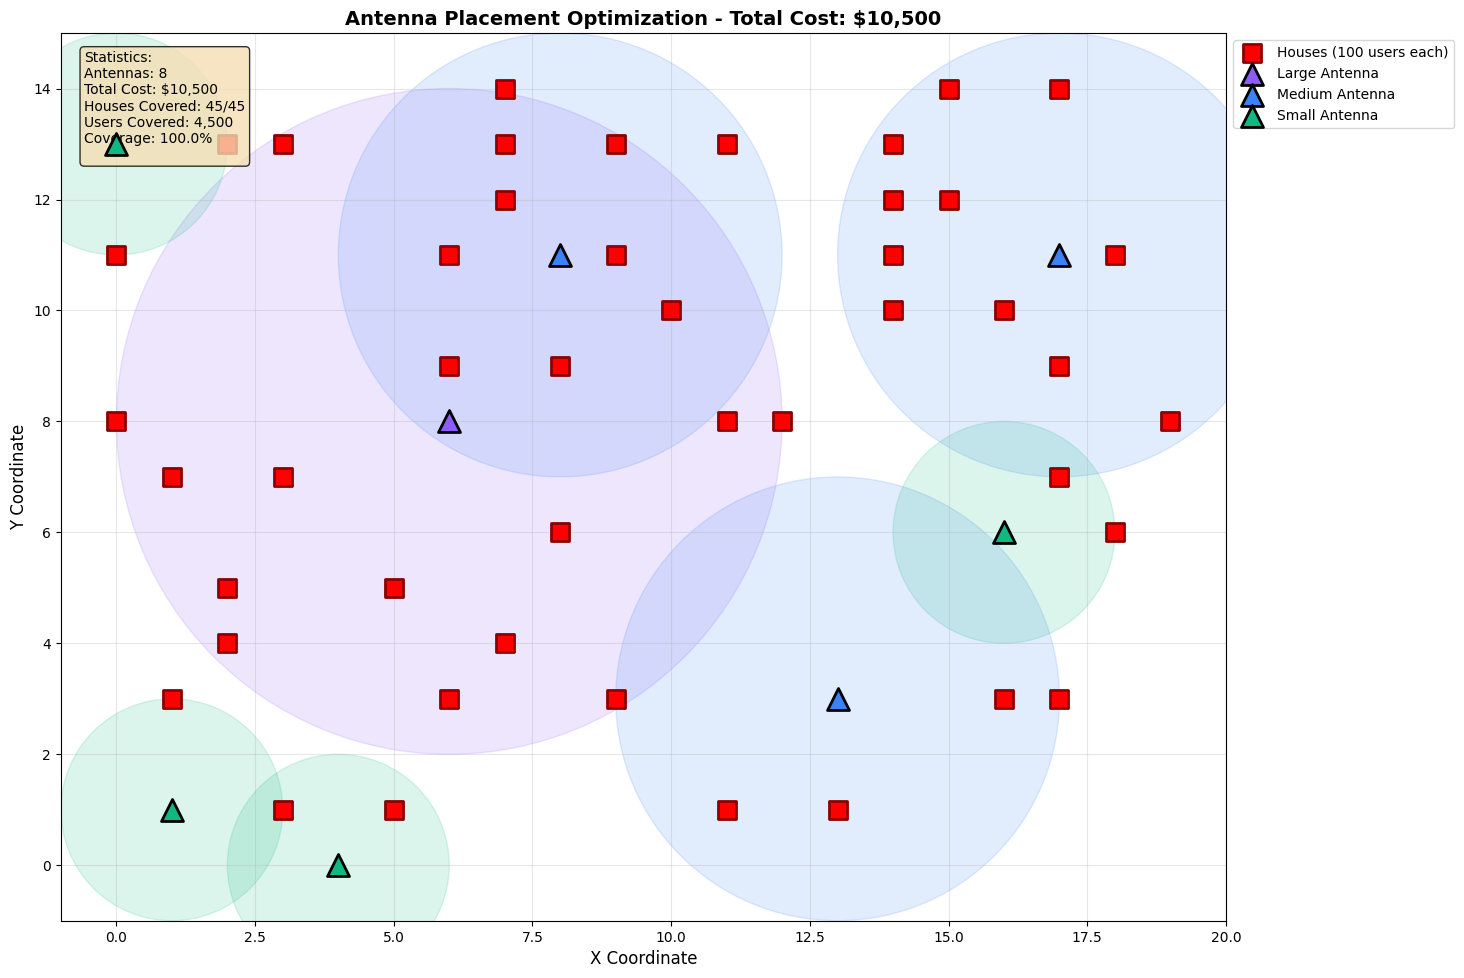

\nAntenna Breakdown by Type:
  Large: 1 antenna(s) - $2,000
  Medium: 3 antenna(s) - $4,500
  Small: 4 antenna(s) - $4,000


In [5]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define colors for each antenna type
antenna_colors = {
    AntennaType.SMALL: '#10B981',   # Green
    AntennaType.MEDIUM: '#3B82F6',  # Blue
    AntennaType.LARGE: '#8B5CF6',   # Purple
}

# Plot coverage circles first (so they're in the background)
for antenna in result['antennas']:
    color = antenna_colors[antenna['type']]
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=color, alpha=0.15, zorder=1)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas
antenna_types = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    if ant_type not in antenna_types:
        antenna_types[ant_type] = {'x': [], 'y': []}
    antenna_types[ant_type]['x'].append(antenna['x'])
    antenna_types[ant_type]['y'].append(antenna['y'])

for ant_type, coords in antenna_types.items():
    color = antenna_colors[ant_type]
    ax.scatter(coords['x'], coords['y'], c=color, s=250, marker='^', 
              label=f'{ant_type.value} Antenna', zorder=4, 
              edgecolors='black', linewidth=2)

# Set grid
ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Antenna Placement Optimization - Total Cost: ${result["total_cost"]:,}', 
            fontsize=14, fontweight='bold')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Add statistics text box
stats_text = f"""Statistics:
Antennas: {len(result['antennas'])}
Total Cost: ${result['total_cost']:,}
Houses Covered: {result['houses_covered']}/{result['total_houses']}
Users Covered: {result['users_covered']:,}
Coverage: {result['coverage_percentage']:.1f}%
"""
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print antenna breakdown
print("\\nAntenna Breakdown by Type:")
antenna_counts = {}
antenna_costs = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    antenna_counts[ant_type] = antenna_counts.get(ant_type, 0) + 1
    antenna_costs[ant_type] = antenna_costs.get(ant_type, 0) + antenna['cost']

for ant_type in sorted(antenna_counts.keys(), key=lambda x: x.value):
    count = antenna_counts[ant_type]
    cost = antenna_costs[ant_type]
    print(f"  {ant_type.value}: {count} antenna(s) - ${cost:,}")

## Test with Different Grid Sizes

Let's test how the algorithm performs on different grid sizes.

In [6]:
# Test with different densities
test_configs = [
    {"width": 15, "height": 15, "density": 0.10, "name": "Low Density (10%)"},
    {"width": 20, "height": 15, "density": 0.15, "name": "Medium Density (15%)"},
    {"width": 25, "height": 20, "density": 0.20, "name": "High Density (20%)"},
]

results_comparison = []

for config in test_configs:
    print("\\n" + "="*70)
    print(f"TEST: {config['name']} - {config['width']}x{config['height']} grid")
    print("="*70)
    
    # Generate houses
    np.random.seed(42)
    num_houses = int(config['width'] * config['height'] * config['density'])
    test_houses = []
    while len(test_houses) < num_houses:
        x = np.random.randint(0, config['width'])
        y = np.random.randint(0, config['height'])
        if (x, y) not in test_houses:
            test_houses.append((x, y))
    
    # Run optimization
    algorithm = GreedyAlgorithm(
        width=config['width'],
        height=config['height'],
        antenna_specs=ANTENNA_SPECS,
        houses=test_houses
    )
    
    result = algorithm.optimize()
    results_comparison.append({
        "name": config['name'],
        "houses": num_houses,
        "users": result['total_users'],
        "antennas": len(result['antennas']),
        "cost": result['total_cost'],
        "cost_per_user": result['total_cost'] / result['total_users'] if result['total_users'] > 0 else 0
    })

# Display comparison
print("\\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"{'Scenario':<25} {'Houses':<10} {'Users':<10} {'Antennas':<12} {'Cost':<12} {'$/User':<10}")
print("-" * 70)
for r in results_comparison:
    print(f"{r['name']:<25} {r['houses']:<10} {r['users']:<10,} {r['antennas']:<12} ${r['cost']:<11,} ${r['cost_per_user']:.2f}")

print("\\nKey Insights:")
print(f"  - Cost per user ranges from ${min(r['cost_per_user'] for r in results_comparison):.2f} to ${max(r['cost_per_user'] for r in results_comparison):.2f}")
print(f"  - Higher density areas may be more cost-efficient per user")

\n======================================================================
TEST: Low Density (10%) - 15x15 grid
Initialized: 15x15 grid, 22 houses, 2200 total users
\nStarting greedy optimization...
  Iteration 1: Placed Large at (8, 6), covered 15 new houses, total coverage: 68.2%
  Iteration 2: Placed Small at (12, 13), covered 4 new houses, total coverage: 86.4%
  Iteration 3: Placed Medium at (0, 7), covered 2 new houses, total coverage: 95.5%
  Iteration 4: Placed Small at (12, 9), covered 1 new houses, total coverage: 100.0%
\n✓ Optimization complete!
  Antennas placed: 4
  Total cost: $5,500
  Houses covered: 22/22
  Users covered: 2,200/2,200 (100.0%)
\n======================================================================
TEST: Medium Density (15%) - 20x15 grid
Initialized: 20x15 grid, 45 houses, 4500 total users
\nStarting greedy optimization...
  Iteration 1: Placed Large at (6, 8), covered 21 new houses, total coverage: 46.7%
  Iteration 2: Placed Medium at (17, 11), covered 

## Algorithm Summary

**Key Features:**
- **Greedy approach**: Selects antenna placement with best cost per house covered
- **Constraint**: Antennas cannot be placed on houses
- **Goal**: 100% coverage with minimum cost
- **Complexity**: O(T × W × H × N) per iteration
  - T = 3 antenna types
  - W × H = grid size
  - N = number of houses
  
**How it works:**
1. For every empty position on the grid
2. Try all 3 antenna types
3. Calculate how many new houses would be covered
4. Select the antenna with lowest cost per new house
5. Repeat until all houses are covered

## Key Takeaways

1. **Simplified Model**: 3 antenna types, 100 users per house, straightforward cost optimization

2. **100% Coverage**: Algorithm guarantees all houses are covered

3. **Cost Efficiency**: Greedy selection based on cost per house covered minimizes total deployment cost

4. **Practical Constraint**: Antennas cannot overlap with houses, simulating real-world placement restrictions

5. **Scalability**: Works efficiently on various grid sizes and house densities

6. **Trade-offs**:
   - Small antennas: Better for isolated houses
   - Medium antennas: Good balance
   - Large antennas: Efficient for clustered houses

---

# Algorithm 2: Genetic Algorithm

The genetic algorithm uses evolutionary principles to optimize antenna placement. Unlike the greedy algorithm which makes sequential decisions, the genetic algorithm maintains a population of solutions and evolves them over generations.

In [ ]:
class GeneticAlgorithm:
    """Genetic algorithm for antenna placement optimization."""
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]],
        population_size: int = 50,
        generations: int = 100,
        mutation_rate: float = 0.1,
        crossover_rate: float = 0.7
    ):
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        print(f"Initialized Genetic Algorithm: {width}x{height} grid, {len(houses)} houses")
    
    def create_random_solution(self, max_antennas: int = 15) -> List[Dict]:
        num_antennas = random.randint(1, max_antennas)
        solution = []
        for _ in range(num_antennas):
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if (x, y) in self.houses:
                continue
            antenna_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[antenna_type]
            solution.append({"x": x, "y": y, "type": antenna_type, "radius": spec.radius, "cost": spec.cost})
        return solution
    
    def calculate_fitness(self, solution: List[Dict]) -> float:
        if not solution:
            return -float('inf')
        covered_houses = set()
        for antenna in solution:
            for house_x, house_y in self.houses:
                distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
                if distance <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        coverage_ratio = len(covered_houses) / len(self.houses) if self.houses else 0
        total_cost = sum(ant['cost'] for ant in solution)
        max_possible_cost = len(solution) * max(spec.cost for spec in self.antenna_specs.values())
        normalized_cost = total_cost / max_possible_cost if max_possible_cost > 0 else 0
        fitness = 100 * coverage_ratio - normalized_cost
        if coverage_ratio >= 1.0:
            fitness += 50
        return fitness
    
    def initialize_population(self) -> List[List[Dict]]:
        return [self.create_random_solution() for _ in range(self.population_size)]
    
    def selection(self, population: List[List[Dict]], fitnesses: List[float]) -> List[List[Dict]]:
        selected = []
        for _ in range(len(population)):
            tournament_indices = random.sample(range(len(population)), 3)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
            selected.append(deepcopy(population[winner_idx]))
        return selected
    
    def crossover(self, parent1: List[Dict], parent2: List[Dict]) -> Tuple[List[Dict], List[Dict]]:
        if random.random() > self.crossover_rate or not parent1 or not parent2:
            return deepcopy(parent1), deepcopy(parent2)
        point1 = random.randint(0, len(parent1))
        point2 = random.randint(0, len(parent2))
        return parent1[:point1] + parent2[point2:], parent2[:point2] + parent1[point1:]
    
    def mutate(self, solution: List[Dict]) -> List[Dict]:
        if random.random() > self.mutation_rate:
            return solution
        mutation_type = random.choice(['add', 'remove', 'modify'])
        if mutation_type == 'add':
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if (x, y) not in self.houses:
                antenna_type = random.choice(list(self.antenna_specs.keys()))
                spec = self.antenna_specs[antenna_type]
                solution.append({"x": x, "y": y, "type": antenna_type, "radius": spec.radius, "cost": spec.cost})
        elif mutation_type == 'remove' and solution:
            solution.pop(random.randint(0, len(solution) - 1))
        elif mutation_type == 'modify' and solution:
            idx = random.randint(0, len(solution) - 1)
            antenna_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[antenna_type]
            solution[idx].update({"type": antenna_type, "radius": spec.radius, "cost": spec.cost})
        return solution
    
    def optimize(self) -> Dict:
        print("\\nStarting genetic algorithm optimization...")
        start_time = time.time()
        population = self.initialize_population()
        best_solution = None
        best_fitness = -float('inf')
        
        for generation in range(self.generations):
            fitnesses = [self.calculate_fitness(sol) for sol in population]
            gen_best_idx = fitnesses.index(max(fitnesses))
            if fitnesses[gen_best_idx] > best_fitness:
                best_fitness = fitnesses[gen_best_idx]
                best_solution = deepcopy(population[gen_best_idx])
            if generation % 10 == 0 or generation == self.generations - 1:
                print(f"  Generation {generation}: Best Fitness = {best_fitness:.2f}, Avg = {sum(fitnesses)/len(fitnesses):.2f}")
            selected = self.selection(population, fitnesses)
            next_generation = []
            for i in range(0, len(selected), 2):
                parent1, parent2 = selected[i], selected[i + 1] if i + 1 < len(selected) else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                next_generation.extend([self.mutate(child1), self.mutate(child2)])
            population = next_generation[:self.population_size]
        
        covered_houses = set()
        for antenna in best_solution:
            for house_x, house_y in self.houses:
                if ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5 <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        
        total_houses = len(self.houses)
        houses_covered = len(covered_houses)
        users_covered = houses_covered * USERS_PER_HOUSE
        coverage_percentage = (houses_covered / total_houses * 100) if total_houses > 0 else 0
        total_cost = sum(ant['cost'] for ant in best_solution)
        execution_time_ms = (time.time() - start_time) * 1000
        
        print(f"\\n✓ Genetic Algorithm complete!")
        print(f"  Antennas: {len(best_solution)}, Cost: ${total_cost:,}, Coverage: {coverage_percentage:.1f}%")
        
        return {
            "antennas": best_solution,
            "houses_covered": houses_covered,
            "total_houses": total_houses,
            "users_covered": users_covered,
            "total_users": total_houses * USERS_PER_HOUSE,
            "coverage_percentage": coverage_percentage,
            "total_cost": total_cost,
            "execution_time_ms": execution_time_ms
        }

print("GeneticAlgorithm class defined successfully!")

In [ ]:
# Comparison: Run both algorithms on the same grid
print("="*70)
print("RUNNING BOTH ALGORITHMS ON THE SAME GRID")
print("="*70)

# Run Greedy Algorithm
print("\\n1️⃣ Running Greedy Algorithm...")
greedy_algo = GreedyAlgorithm(GRID_WIDTH, GRID_HEIGHT, ANTENNA_SPECS, houses)
greedy_result = greedy_algo.optimize()

print(f"   ✓ Greedy completed in {greedy_result['execution_time_ms']:.2f} ms")
print(f"   📡 Antennas placed: {len(greedy_result['antennas'])}")
print(f"   💰 Total cost: ${greedy_result['total_cost']:,}")
print(f"   📊 Coverage: {greedy_result['coverage_percentage']:.1f}%")

# Run Genetic Algorithm
print("\\n2️⃣ Running Genetic Algorithm...")
genetic_algo = GeneticAlgorithm(
    GRID_WIDTH, GRID_HEIGHT, ANTENNA_SPECS, houses,
    population_size=50,
    generations=100,
    mutation_rate=0.1,
    crossover_rate=0.7
)
genetic_result = genetic_algo.optimize()

print(f"   ✓ Genetic completed in {genetic_result['execution_time_ms']:.2f} ms")
print(f"   📡 Antennas placed: {len(genetic_result['antennas'])}")
print(f"   💰 Total cost: ${genetic_result['total_cost']:,}")
print(f"   📊 Coverage: {genetic_result['coverage_percentage']:.1f}%")

# Detailed Comparison
print("\\n" + "="*70)
print("DETAILED COMPARISON")
print("="*70)
print(f"{'Metric':<30} {'Greedy':<20} {'Genetic':<20}")
print("-" * 70)
print(f"{'Antennas Placed':<30} {len(greedy_result['antennas']):<20} {len(genetic_result['antennas']):<20}")
print(f"{'Total Cost':<30} ${greedy_result['total_cost']:<19,} ${genetic_result['total_cost']:<19,}")
print(f"{'Houses Covered':<30} {greedy_result['houses_covered']}/{greedy_result['total_houses']:<15} {genetic_result['houses_covered']}/{genetic_result['total_houses']:<15}")
print(f"{'Coverage %':<30} {greedy_result['coverage_percentage']:<19.1f}% {genetic_result['coverage_percentage']:<19.1f}%")
print(f"{'Cost per User':<30} ${greedy_result['total_cost']/greedy_result['users_covered']:<19.2f} ${genetic_result['total_cost']/genetic_result['users_covered']:<19.2f}")
print(f"{'Execution Time (ms)':<30} {greedy_result['execution_time_ms']:<19.2f} {genetic_result['execution_time_ms']:<19.2f}")
print(f"{'Speed Ratio':<30} {'1x (baseline)':<20} {f'{genetic_result["execution_time_ms"]/greedy_result["execution_time_ms"]:.1f}x slower':<20}")
print("="*70)

# Determine winner
print("\\n🏆 WINNER DETERMINATION:")
if greedy_result['coverage_percentage'] >= 100 and genetic_result['coverage_percentage'] >= 100:
    cost_diff = abs(greedy_result['total_cost'] - genetic_result['total_cost'])
    cost_savings_pct = (cost_diff / max(greedy_result['total_cost'], genetic_result['total_cost'])) * 100
    
    if greedy_result['total_cost'] < genetic_result['total_cost']:
        print(f"   Winner: Greedy Algorithm")
        print(f"   Reason: ${cost_diff:,} cheaper ({cost_savings_pct:.1f}% savings) with full coverage")
    elif genetic_result['total_cost'] < greedy_result['total_cost']:
        print(f"   Winner: Genetic Algorithm")
        print(f"   Reason: ${cost_diff:,} cheaper ({cost_savings_pct:.1f}% savings) with full coverage")
    else:
        print(f"   Result: Tie - Both algorithms achieved same cost and coverage")
elif greedy_result['coverage_percentage'] > genetic_result['coverage_percentage']:
    print(f"   Winner: Greedy Algorithm")
    print(f"   Reason: Better coverage ({greedy_result['coverage_percentage']:.1f}% vs {genetic_result['coverage_percentage']:.1f}%)")
else:
    print(f"   Winner: Genetic Algorithm")
    print(f"   Reason: Better coverage ({genetic_result['coverage_percentage']:.1f}% vs {greedy_result['coverage_percentage']:.1f}%)")

RUNNING BOTH ALGORITHMS ON THE SAME GRID
\n1️⃣ Running Greedy Algorithm...
Initialized: 20x15 grid, 3 houses, 300 total users
\nStarting greedy optimization...


AttributeError: 'list' object has no attribute 'items'

## Compare Both Algorithms

Now let's run both algorithms on the same grid and compare their performance in terms of:
- **Total Cost**: Which algorithm finds cheaper solutions?
- **Coverage**: Do both achieve 100% coverage?
- **Number of Antennas**: Which uses fewer antennas?
- **Execution Time**: Speed comparison
- **Solution Quality**: Overall cost-effectiveness

In [ ]:
# Visualization for Genetic Algorithm
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot coverage circles
for antenna in genetic_result['antennas']:
    color = antenna_colors[antenna['type']]
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=color, alpha=0.15, zorder=1)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas
antenna_types_genetic = {}
for antenna in genetic_result['antennas']:
    ant_type = antenna['type']
    if ant_type not in antenna_types_genetic:
        antenna_types_genetic[ant_type] = {'x': [], 'y': []}
    antenna_types_genetic[ant_type]['x'].append(antenna['x'])
    antenna_types_genetic[ant_type]['y'].append(antenna['y'])

for ant_type, coords in antenna_types_genetic.items():
    color = antenna_colors[ant_type]
    ax.scatter(coords['x'], coords['y'], c=color, s=250, marker='^', 
              label=f'{ant_type.value} Antenna', zorder=4, 
              edgecolors='black', linewidth=2)

ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Genetic Algorithm - Total Cost: ${genetic_result["total_cost"]:,}', 
            fontsize=14, fontweight='bold')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

stats_text = f"""Statistics:
Antennas: {len(genetic_result['antennas'])}
Total Cost: ${genetic_result['total_cost']:,}
Houses Covered: {genetic_result['houses_covered']}/{genetic_result['total_houses']}
Users Covered: {genetic_result['users_covered']:,}
Coverage: {genetic_result['coverage_percentage']:.1f}%
"""
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## Side-by-Side Visualization

Let's visualize both solutions side by side to see the differences in antenna placement strategies.

In [ ]:
# Side-by-side visualization of both algorithms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

antenna_colors = {
    AntennaType.SMALL: 'green',
    AntennaType.MEDIUM: 'blue',
    AntennaType.LARGE: 'purple'
}

# ----- LEFT: Greedy Algorithm -----
ax1.set_title(f'Greedy Algorithm\\nCost: ${greedy_result["total_cost"]:,} | Antennas: {len(greedy_result["antennas"])}', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('X Coordinate', fontsize=12)
ax1.set_ylabel('Y Coordinate', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Draw coverage circles for greedy
for antenna in greedy_result['antennas']:
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=antenna_colors[antenna['type']], alpha=0.15)
    ax1.add_patch(circle)

# Plot houses on greedy
if houses:
    houses_x, houses_y = zip(*houses)
    ax1.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
               label='Houses', zorder=3, edgecolors='darkred', linewidth=2)

# Plot greedy antennas
for ant_type in AntennaType:
    ant_coords = [(a['x'], a['y']) for a in greedy_result['antennas'] if a['type'] == ant_type]
    if ant_coords:
        x_coords, y_coords = zip(*ant_coords)
        ax1.scatter(x_coords, y_coords, c=antenna_colors[ant_type], s=250, marker='^', 
                   label=f'{ant_type.value}', zorder=4, edgecolors='black', linewidth=2)

ax1.set_xlim(-1, GRID_WIDTH)
ax1.set_ylim(-1, GRID_HEIGHT)
ax1.legend(loc='upper right', fontsize=10)

# ----- RIGHT: Genetic Algorithm -----
ax2.set_title(f'Genetic Algorithm\\nCost: ${genetic_result["total_cost"]:,} | Antennas: {len(genetic_result["antennas"])}', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('X Coordinate', fontsize=12)
ax2.set_ylabel('Y Coordinate', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# Draw coverage circles for genetic
for antenna in genetic_result['antennas']:
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=antenna_colors[antenna['type']], alpha=0.15)
    ax2.add_patch(circle)

# Plot houses on genetic
if houses:
    ax2.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
               label='Houses', zorder=3, edgecolors='darkred', linewidth=2)

# Plot genetic antennas
for ant_type in AntennaType:
    ant_coords = [(a['x'], a['y']) for a in genetic_result['antennas'] if a['type'] == ant_type]
    if ant_coords:
        x_coords, y_coords = zip(*ant_coords)
        ax2.scatter(x_coords, y_coords, c=antenna_colors[ant_type], s=250, marker='^', 
                   label=f'{ant_type.value}', zorder=4, edgecolors='black', linewidth=2)

ax2.set_xlim(-1, GRID_WIDTH)
ax2.set_ylim(-1, GRID_HEIGHT)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\\n✓ Side-by-side visualization complete!")

## Visualize Genetic Algorithm Solution Only

Let's see the genetic algorithm's solution independently:

In [ ]:
# Use the same grid as greedy to run genetic algorithm independently
genetic_algo_standalone = GeneticAlgorithm(
    GRID_WIDTH, GRID_HEIGHT, houses, ANTENNA_SPECS,
    population_size=50,
    generations=100,
    mutation_rate=0.1,
    crossover_rate=0.7
)

print("Running Genetic Algorithm (standalone)...")
genetic_result_standalone = genetic_algo_standalone.optimize()

print(f"\\n✓ Genetic Algorithm Results:")
print(f"   📡 Antennas placed: {len(genetic_result_standalone['antennas'])}")
print(f"   💰 Total cost: ${genetic_result_standalone['total_cost']:,}")
print(f"   🏠 Houses covered: {genetic_result_standalone['houses_covered']}/{genetic_result_standalone['total_houses']}")
print(f"   📊 Coverage: {genetic_result_standalone['coverage_percentage']:.1f}%")
print(f"   ⏱️ Execution time: {genetic_result_standalone['execution_time_ms']:.2f} ms")

In [ ]:
# Visualization for Genetic Algorithm standalone result
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title(f'Genetic Algorithm - Antenna Placement\\nCost: ${genetic_result_standalone["total_cost"]:,} | Coverage: {genetic_result_standalone["coverage_percentage"]:.1f}%', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

antenna_colors = {
    AntennaType.SMALL: 'green',
    AntennaType.MEDIUM: 'blue',
    AntennaType.LARGE: 'purple'
}

# Draw coverage circles
for antenna in genetic_result_standalone['antennas']:
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=antenna_colors[antenna['type']], alpha=0.15)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas by type
for ant_type in AntennaType:
    ant_coords = [(a['x'], a['y']) for a in genetic_result_standalone['antennas'] if a['type'] == ant_type]
    if ant_coords:
        x_coords, y_coords = zip(*ant_coords)
        ax.scatter(x_coords, y_coords, c=antenna_colors[ant_type], s=250, marker='^', 
                  label=f'{ant_type.value} Antenna', zorder=4, edgecolors='black', linewidth=2)

ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.legend(loc='upper right', fontsize=11)

# Add stats box
stats_text = f"""Genetic Algorithm Statistics:
━━━━━━━━━━━━━━━━━━━━━━
Total Antennas: {len(genetic_result_standalone['antennas'])}
Total Cost: ${genetic_result_standalone['total_cost']:,}
Coverage: {genetic_result_standalone['coverage_percentage']:.1f}%
Houses Covered: {genetic_result_standalone['houses_covered']}/{genetic_result_standalone['total_houses']}
"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

print("\\n✓ Genetic algorithm visualization complete!")

In [ ]:
class GeneticAlgorithm:
    """Genetic algorithm for antenna placement optimization."""
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]],
        population_size: int = 50,
        generations: int = 100,
        mutation_rate: float = 0.1,
        crossover_rate: float = 0.7
    ):
        """
        Initialize the genetic algorithm.
        
        Args:
            width: Grid width
            height: Grid height
            antenna_specs: Dictionary of antenna specifications
            houses: List of house coordinates
            population_size: Number of solutions in population
            generations: Number of generations to evolve
            mutation_rate: Probability of mutation
            crossover_rate: Probability of crossover
        """
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        print(f"Initialized Genetic Algorithm: {width}x{height} grid, {len(houses)} houses")
        print(f"Population: {population_size}, Generations: {generations}")
    
    def create_random_solution(self, max_antennas: int = 15) -> List[Dict]:
        """Create a random solution (chromosome)."""
        num_antennas = random.randint(1, max_antennas)
        solution = []
        
        for _ in range(num_antennas):
            # Random position
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            
            # Skip if on a house
            if (x, y) in self.houses:
                continue
            
            # Random antenna type
            antenna_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[antenna_type]
            
            solution.append({
                "x": x,
                "y": y,
                "type": antenna_type,
                "radius": spec.radius,
                "cost": spec.cost
            })
        
        return solution
    
    def calculate_fitness(self, solution: List[Dict]) -> float:
        """
        Calculate fitness of a solution.
        Fitness = coverage_weight * coverage_ratio - cost_weight * normalized_cost
        Higher fitness is better.
        """
        if not solution:
            return -float('inf')
        
        # Calculate coverage
        covered_houses = set()
        for antenna in solution:
            for house_x, house_y in self.houses:
                distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
                if distance <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        
        coverage_ratio = len(covered_houses) / len(self.houses) if self.houses else 0
        
        # Calculate total cost
        total_cost = sum(ant['cost'] for ant in solution)
        max_possible_cost = len(solution) * max(spec.cost for spec in self.antenna_specs.values())
        normalized_cost = total_cost / max_possible_cost if max_possible_cost > 0 else 0
        
        # Fitness function: prioritize coverage, penalize cost
        coverage_weight = 100  # Very high weight for coverage
        cost_weight = 1        # Lower weight for cost
        
        fitness = coverage_weight * coverage_ratio - cost_weight * normalized_cost
        
        # Bonus for 100% coverage
        if coverage_ratio >= 1.0:
            fitness += 50
        
        return fitness
    
    def initialize_population(self) -> List[List[Dict]]:
        """Create initial population of random solutions."""
        return [self.create_random_solution() for _ in range(self.population_size)]
    
    def selection(self, population: List[List[Dict]], fitnesses: List[float]) -> List[List[Dict]]:
        """Tournament selection: choose best from random subset."""
        selected = []
        tournament_size = 3
        
        for _ in range(len(population)):
            # Random tournament
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
            selected.append(deepcopy(population[winner_idx]))
        
        return selected
    
    def crossover(self, parent1: List[Dict], parent2: List[Dict]) -> Tuple[List[Dict], List[Dict]]:
        """Single-point crossover: combine two parent solutions."""
        if random.random() > self.crossover_rate or not parent1 or not parent2:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Single-point crossover
        point1 = random.randint(0, len(parent1))
        point2 = random.randint(0, len(parent2))
        
        child1 = parent1[:point1] + parent2[point2:]
        child2 = parent2[:point2] + parent1[point1:]
        
        return child1, child2
    
    def mutate(self, solution: List[Dict]) -> List[Dict]:
        """Apply random mutations to solution."""
        if random.random() > self.mutation_rate:
            return solution
        
        mutation_type = random.choice(['add', 'remove', 'modify'])
        
        if mutation_type == 'add':
            # Add new antenna
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if (x, y) not in self.houses:
                antenna_type = random.choice(list(self.antenna_specs.keys()))
                spec = self.antenna_specs[antenna_type]
                solution.append({
                    "x": x, "y": y, "type": antenna_type,
                    "radius": spec.radius, "cost": spec.cost
                })
        
        elif mutation_type == 'remove' and solution:
            # Remove random antenna
            solution.pop(random.randint(0, len(solution) - 1))
        
        elif mutation_type == 'modify' and solution:
            # Modify random antenna
            idx = random.randint(0, len(solution) - 1)
            antenna_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[antenna_type]
            solution[idx]['type'] = antenna_type
            solution[idx]['radius'] = spec.radius
            solution[idx]['cost'] = spec.cost
        
        return solution
    
    def optimize(self) -> Dict:
        """Run the genetic algorithm."""
        print("\\nStarting genetic algorithm optimization...")
        
        start_time = time.time()
        
        # Initialize population
        population = self.initialize_population()
        best_solution = None
        best_fitness = -float('inf')
        
        for generation in range(self.generations):
            # Evaluate fitness
            fitnesses = [self.calculate_fitness(sol) for sol in population]
            
            # Track best solution
            gen_best_idx = fitnesses.index(max(fitnesses))
            if fitnesses[gen_best_idx] > best_fitness:
                best_fitness = fitnesses[gen_best_idx]
                best_solution = deepcopy(population[gen_best_idx])
            
            # Print progress
            if generation % 10 == 0 or generation == self.generations - 1:
                avg_fitness = sum(fitnesses) / len(fitnesses)
                print(f"  Generation {generation}: Best Fitness = {best_fitness:.2f}, Avg = {avg_fitness:.2f}")
            
            # Selection
            selected = self.selection(population, fitnesses)
            
            # Crossover and Mutation
            next_generation = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < len(selected) else selected[0]
                
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                next_generation.extend([child1, child2])
            
            population = next_generation[:self.population_size]
        
        # Calculate final statistics for best solution
        covered_houses = set()
        for antenna in best_solution:
            for house_x, house_y in self.houses:
                distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
                if distance <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        
        total_houses = len(self.houses)
        houses_covered = len(covered_houses)
        users_covered = houses_covered * USERS_PER_HOUSE
        total_users = total_houses * USERS_PER_HOUSE
        coverage_percentage = (houses_covered / total_houses * 100) if total_houses > 0 else 0
        total_cost = sum(ant['cost'] for ant in best_solution)
        execution_time_ms = (time.time() - start_time) * 1000
        
        print(f"\\n✓ Genetic Algorithm complete!")
        print(f"  Antennas placed: {len(best_solution)}")
        print(f"  Total cost: ${total_cost:,}")
        print(f"  Houses covered: {houses_covered}/{total_houses} ({coverage_percentage:.1f}%)")
        print(f"  Users covered: {users_covered:,}/{total_users:,}")
        
        return {
            "antennas": best_solution,
            "houses_covered": houses_covered,
            "total_houses": total_houses,
            "users_covered": users_covered,
            "total_users": total_users,
            "coverage_percentage": coverage_percentage,
            "total_cost": total_cost,
            "execution_time_ms": execution_time_ms
        }

print("GeneticAlgorithm class defined successfully!")

## Genetic Algorithm Overview

**Key Concepts:**
- **Chromosome**: A solution representing antenna placements (list of antennas)
- **Population**: Collection of candidate solutions
- **Fitness**: Evaluated based on coverage and cost
- **Selection**: Choose best solutions for reproduction
- **Crossover**: Combine two parent solutions
- **Mutation**: Random changes to maintain diversity

---

# Algorithm 2: Genetic Algorithm

The genetic algorithm uses evolutionary principles to optimize antenna placement. Unlike the greedy algorithm which makes sequential decisions, the genetic algorithm maintains a population of solutions and evolves them over generations.